### examining robinson-foulds distances on nearby gene trees

In [1]:
# pip install strange
# conda install seq-gen -c bioconda
# conda install toytree -c eaton-lab
# #strange includes local raxml-ng 

In [1]:
import numpy as np
import pandas as pd
import strange
import toytree
import toyplot
import seaborn as sns
from matplotlib import pyplot as plt
import os
import ast
from numba import jit
from scipy import stats

In [2]:
assert int(toytree.__version__.split(".")[-1]) >= 19, "update toytree"
print("toytree", toytree.__version__)
print("strange", strange.__version__)

('toytree', '0.1.19')
('strange', '0.2.1-dev')


### RF distance of neighboring trees

In [2]:
imb = toytree.tree("((((((((((((((((((((1,2),3),4),5),6),7),8),9),10),11),12),13),14),15),16),17),18),19),20),21);").mod.make_ultrametric()
imb5 = imb.mod.node_scale_root_height(5)
imb5.draw();
Ne = 250000
mut = 1e-8
kwargs = {
    "workdir": "../tests",
    "mutation_rate": mut,
    "recombination_rate": 1e-9,
    "theta": Ne*mut*4,
    "length": int(1e6), 
    "get_sequences": False,
    "random_seed": 42,
}

# setup simulation objects
simi5 = strange.Coalseq(tree=imb5, name="simi5", **kwargs)
#simi5.make_cladesarr()

2 1 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21

### function for calculating normalized robinson-foulds between two toytree objs

In [6]:
def get_normalized_rf(ttree1,ttree2):
    rf,rfmax=ttree1.treenode.robinson_foulds(ttree2.treenode,unrooted_trees=True)[0:2]
    return(float(rf)/rfmax)

In [15]:
tree1 = toytree.tree(simi5.tree_table.mstree[0])
tree2 = toytree.tree(simi5.tree_table.mstree[10])

In [16]:
get_normalized_rf(tree1,tree2)

0.7777777777777778

nice.

### for each mstree, calculate the average robinson-foulds val of the trees x fragments away.

In [89]:
def calc_avg_rfs_away(mstrees,idx_away):
    '''
    returns the average value of the robinson-foulds distance between all gene trees and 
    the two gene trees that are `idx_away` distant from them.
    '''
    counter = 0
    summedrf = 0
    for idx in range(idx_away,(len(mstrees)-idx_away)):
        tree1 = toytree.tree(mstrees[idx])
        tree2 = toytree.tree(mstrees[idx+idx_away])
        tree3 = toytree.tree(mstrees[idx-idx_away])
        rfnorm1 = get_normalized_rf(tree1,tree2)
        rfnorm2 = get_normalized_rf(tree1,tree3)
        summedrf += np.mean([rfnorm1,rfnorm2])
        counter += 1
    return(float(summedrf)/counter)

In [90]:
def get_all_rfs_idx_away(mstrees,idx_away):
    '''
    fills an array with robinson-foulds distances between each gene tree and the gene trees that
    are `idx_away` distant from it. Averaging this should give result in `calc_avg_rfs_away()`
    '''
    arr = np.zeros((2,len(range(idx_away,(len(mstrees)-idx_away)))))
    for idx in range(idx_away,(len(mstrees)-idx_away)):
        tree1 = toytree.tree(mstrees[idx])
        tree2 = toytree.tree(mstrees[idx+idx_away])
        tree3 = toytree.tree(mstrees[idx-idx_away])
        rfnorm1 = get_normalized_rf(tree1,tree2)
        rfnorm2 = get_normalized_rf(tree1,tree3)
        arr[0,idx-idx_away] = rfnorm1
        arr[1,idx-idx_away] = rfnorm2

    return(arr)

### First, let's calculate the average robinson-foulds distance between gene trees and those that are 1,2,3,etc. steps away.

In [ ]:
print(calc_avg_rfs_away(simi5.tree_table.mstree,1))
print(calc_avg_rfs_away(simi5.tree_table.mstree,2))
print(calc_avg_rfs_away(simi5.tree_table.mstree,3))
print(calc_avg_rfs_away(simi5.tree_table.mstree,4))
print(calc_avg_rfs_away(simi5.tree_table.mstree,5))
print(calc_avg_rfs_away(simi5.tree_table.mstree,6))
print(calc_avg_rfs_away(simi5.tree_table.mstree,7))
print(calc_avg_rfs_away(simi5.tree_table.mstree,8))

Great, cool. Nearby trees are similar, and they become less similar as we move away. But let's just confirm that this isn't being driven primarily by the fact that some neighboring topologies might be identical.

e.g. what if when the topology **does** change, it doesn't necessarily change to a nearby topology.

### Condense identical neighboring trees so that each neighboring tree has a different topology.

In [139]:
# condensing
treelist = [simi5.tree_table.mstree[0]]
currtopo = toytree.tree(simi5.tree_table.mstree[0])
for i in range(len(simi5.tree_table.mstree)):
    itertree = toytree.tree(simi5.tree_table.mstree[i])
    if get_normalized_rf(currtopo,itertree) > 0:
        treelist.append(simi5.tree_table.mstree[i])
        currtopo = itertree

In [144]:
print(calc_avg_rfs_away(treelist,1))
print(calc_avg_rfs_away(treelist,2))
print(calc_avg_rfs_away(treelist,3))
print(calc_avg_rfs_away(treelist,4))
print(calc_avg_rfs_away(treelist,5))
print(calc_avg_rfs_away(treelist,6))
print(calc_avg_rfs_away(treelist,7))
print(calc_avg_rfs_away(treelist,8))

0.183278759013
0.313029310573
0.40790649196
0.480454615656
0.538025488249
0.585314307156
0.624177649734
0.656498410175


this shows that even when the topology **does** change at each step away, it tends to change to a similar topology.

### So now that we know nearby trees will probably be similar, how similar do we expect them to be?

To answer this, let's examine the distribution of robinson-foulds values at one gene tree away.

In [17]:
rf1arr=get_all_rfs_idx_away(simi5.tree_table.mstree,1)

In [46]:
rf1arr.shape

(2, 14226)

This array has two rows, where each column corresponds to a gene tree. The entry in the top row corresponds to the distance between the individual gene tree and the one to the right, and the entry in the bottom row corresponds between the individual gene tree and the one to the left.

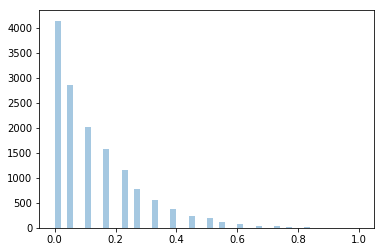

In [47]:
# plot a histogram of the distances between each gene tree and the one immediately to the right
sns.distplot(rf1arr[0],kde=False)
plt.show()

The histogram above includes zeros -- where neighboring gene trees are identical. This seems to fit with the overall distribution.

Let's remove the zeros and see whether "the look" changes (essentially just cropping the previous plot):

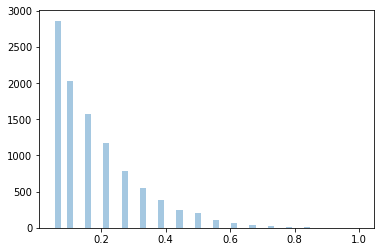

In [36]:
sns.distplot(rf1arr[0][rf1arr[0] != 0],kde = False)
plt.show()

These look really similar. Let's compare them, **normalized**:

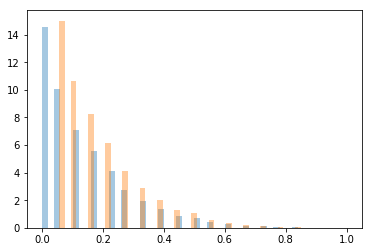

In [93]:
sns.distplot(rf1arr[0],kde = False,norm_hist=True)
sns.distplot(rf1arr[0][rf1arr[0] != 0],kde = False,norm_hist=True)
plt.show()

These seem to be the **same**(ish) shape, which is awesome. Why awesome? Because it implies that the presence of neighboring identical trees is just a product of draws from this same distribution (as opposed to being some extra parameter telling us the probability of remaining the same topology from one mstree to the next).

### What about when we average the distances on either side of the gene tree?

This is getting the average of two pairwise distances... one on either side of our focal gt.

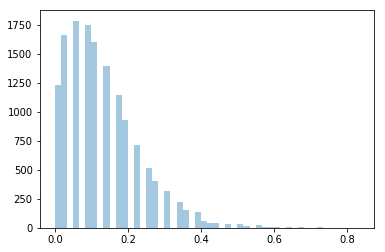

In [42]:
sns.distplot(np.mean(rf1arr,axis=0),kde=False)
plt.show()

This is a weird distribution and isn't necessarily that interesting -- it is just what happens when you take the mean of two draws from this distribution.